<h1> Anchors </h1>
Read paper here: https://homes.cs.washington.edu/~marcotcr/aaai18.pdf
<h5> Imports: </h5>

In [3]:
import os
from argparse import ArgumentParser
from gc import callbacks
from subprocess import call
import PIL
import random
import matplotlib.image as im
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from pytorch_gradcam import gradcam
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.svm import SVC
from torchsummary import summary
from PIL import Image
from matplotlib import cm
from datasets.seven_point_dataset import SevenPointDataset
from datasets.isic_2019 import ISIC2019Dataset

from gradcam import *
from model import SimpleClassifier

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

!pip install alibi
!pip install anchor-exp


<h5> We set up our data, create the model, and load the model with saved checkpoints </h5>

In [41]:
dataset = ISIC2019Dataset('/space/derma-data/isic-2019', batch_size=32, normalize_weights=True, md_choice='all', sampling_rate=-1)

dataset.setup()
early_stopping=False #flag
#optimizer=adam
model = SimpleClassifier(model_name='resnet50',learning_rate=3e-5,
                        class_weights=list(dataset.class_weights),
                        num_classes=dataset.num_classes,
                        check_early_stop=early_stopping,
                        #optimizer=optimizer                            
                        )

#checkpoint = torch.load('saved_model.ckpt') #vgg16, 1e-3, batch 32, 350epoch

checkpoint = torch.load('/u/home/javadov/ai_kit/ai-student-starter-kit/checkpoints/Isicdata_resnet_50.ckpt')
model.load_state_dict(checkpoint['state_dict'])

all: ['anatom_site_general', 'sex', 'age_approx']


The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<All keys matched successfully>

<h5> We call the Trainer to get predictions. For further use, we also get the features and labels out of the predictions</h5>

<h5> Do necessary steps, load a batch of data to work with, forward propage the mdoel </h5>

In [ ]:
if early_stopping:
    callbacks=[EarlyStopping(min_delta=0.001,monitor="val_loss", patience=10,strict=False, verbose=True,mode="min")]
else:
    callbacks=None
print(model)
trainer = pl.Trainer(devices=1,
                     accelerator='gpu',
                     logger=False,
                     callbacks=False,
                     checkpoint_callback=False,
                    )

predictions = trainer.predict(model, dataset.test_dataloader())


features, labels = zip(*predictions)

In [43]:
features = torch.vstack(features)
labels = torch.cat(labels)
(input_original, input, tst, label) = next(iter(dataset.train_dataloader()))
output = model.forward(input)



<h4> Getting an Image instance from the retrieved batch, then processing as needed </h4>

In [44]:
img = np.transpose(input_original.cpu().detach().numpy()[12,:,:,:],(1,2,0))
img1 = img.astype(np.uint8)
pil_img = Image.fromarray(img1).convert('RGB')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   
normed_torch_img


tensor([[[[-2.1008, -2.1008, -2.1179,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008],
          ...,
          [-2.1008, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1008, -2.1008, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0182, -2.0182, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
          ...,
          [-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.7870, -1.7870, -1.8044,  ..., -1.7870, -1.7870, -1.7870],
          [-1.8044, -1.8044, -

<h4> We visualize the raw image </h4>

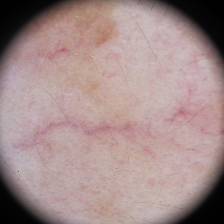

In [45]:
pil_img

<h4> Helper functions </h4>

In [46]:
# Just to be on the safe side. What if tomorrow we get the data from another place?
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf  

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

#to be able to make predictions in batches (multiple preds at once)
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

<h4> Predicting the given instance and also showing the highest logit label </h4>


In [47]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred.squeeze().argmax()

3

<h4> Checking the true label </h4>

In [49]:
label[12]

tensor(3)

<h4> Getting to Anchors: Calling the explainer with some custom parameters </h4>

In [50]:
from alibi.explainers import AnchorImage
image_shape = (224,224,3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(batch_predict, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

<h4> Explaining </h4>

In [51]:
np.random.seed(0)
explanation = explainer.explain(np.array(pill_transf(pil_img)), threshold=.75, p_sample=.5, tau=0.25)

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


<h4> Showing the Clusters (Segments) </h4>

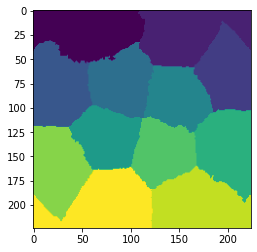

In [52]:
plt.imshow(explanation.segments)


<h4> Showing the Anchor(s) </h4>

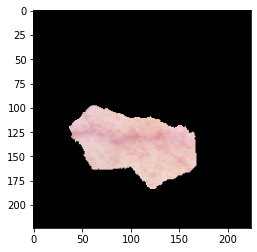

In [53]:
plt.imshow(explanation.anchor)


In [54]:
img = np.transpose(input_original.cpu().detach().numpy()[13,:,:,:],(1,2,0))
img1 = img.astype(np.uint8)
pil_img = Image.fromarray(img1).convert('RGB')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   
normed_torch_img

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

<h2> Experiments </h2> 
<h3> Repeating the above process for several other image instances </h3>

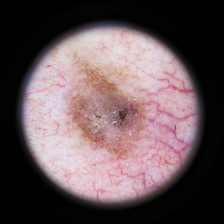

In [55]:
pil_img

In [56]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred.squeeze().argmax()

2

In [57]:
label[13]

tensor(2)

In [58]:
from alibi.explainers import AnchorImage
image_shape = (224,224,3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(batch_predict, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

In [60]:
np.random.seed(1)
explanation = explainer.explain(np.array(pill_transf(pil_img)), threshold=.75, p_sample=.5, tau=0.25)

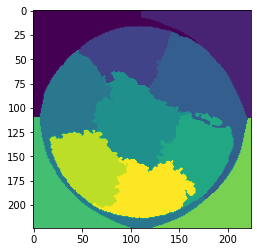

In [61]:
plt.imshow(explanation.segments)


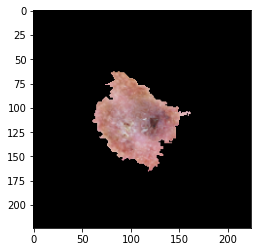

In [62]:
plt.imshow(explanation.anchor)


In [68]:
img = np.transpose(input_original.cpu().detach().numpy()[14,:,:,:],(1,2,0))
img1 = img.astype(np.uint8)
pil_img = Image.fromarray(img1).convert('RGB')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   
normed_torch_img

tensor([[[[ 0.6221,  0.6563,  0.7591,  ...,  0.3481,  0.3481,  0.3309],
          [ 0.6392,  0.6221,  0.7248,  ...,  0.5193,  0.4679,  0.3994],
          [ 0.7077,  0.7419,  0.7591,  ...,  0.4851,  0.4679,  0.3823],
          ...,
          [ 0.5536,  0.6221,  0.6392,  ...,  0.7762,  0.7419,  0.6906],
          [ 0.4508,  0.5022,  0.6049,  ...,  0.7419,  0.5707,  0.4508],
          [ 0.4337,  0.5022,  0.5536,  ...,  0.7591,  0.6049,  0.3823]],

         [[-0.0399, -0.0049,  0.2052,  ..., -0.3200, -0.3725, -0.3901],
          [-0.0399, -0.0399,  0.1877,  ..., -0.1975, -0.2500, -0.3200],
          [ 0.0476,  0.0301,  0.1527,  ..., -0.1975, -0.2150, -0.3025],
          ...,
          [-0.1450, -0.0749,  0.0126,  ...,  0.1001,  0.0651,  0.0301],
          [-0.2675, -0.1800, -0.0574,  ...,  0.0826, -0.1099, -0.3025],
          [-0.3200, -0.2150, -0.1099,  ...,  0.0826, -0.0224, -0.4251]],

         [[ 0.1476,  0.1999,  0.3916,  ..., -0.0615, -0.0964, -0.0964],
          [ 0.1302,  0.1999,  

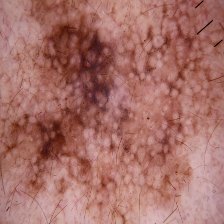

In [69]:
pil_img

In [70]:
from alibi.explainers import AnchorImage
image_shape = (224,224,3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(batch_predict, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

In [74]:
np.random.seed(3)
explanation = explainer.explain(np.array(pill_transf(pil_img)), threshold=.75, p_sample=.5, tau=0.25)

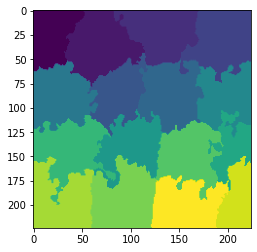

In [75]:
plt.imshow(explanation.segments)


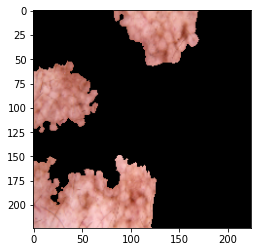

In [76]:
plt.imshow(explanation.anchor)


In [87]:
img = np.transpose(input_original.cpu().detach().numpy()[16,:,:,:],(1,2,0))
img1 = img.astype(np.uint8)
pil_img = Image.fromarray(img1).convert('RGB')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   
normed_torch_img

tensor([[[[ 0.2967,  0.2796,  0.3138,  ...,  0.6221,  0.5193,  0.5022],
          [ 0.3652,  0.2796,  0.3309,  ...,  0.6392,  0.5878,  0.5707],
          [ 0.3138,  0.3138,  0.3309,  ...,  0.6049,  0.6563,  0.6221],
          ...,
          [ 0.9132,  0.9474,  0.9132,  ...,  0.7248,  0.7591,  0.6392],
          [ 0.9132,  0.9303,  0.9132,  ...,  0.7933,  0.6906,  0.6734],
          [ 0.9303,  0.9132,  0.9303,  ...,  0.7591,  0.7762,  0.6734]],

         [[-0.1625, -0.1975, -0.1275,  ...,  0.1352,  0.0651, -0.0749],
          [-0.1975, -0.1099, -0.1099,  ...,  0.2577,  0.1176,  0.0651],
          [-0.1625, -0.1450, -0.0924,  ...,  0.3452,  0.1877,  0.2227],
          ...,
          [ 0.7129,  0.7479,  0.7654,  ...,  0.4328,  0.3978,  0.3102],
          [ 0.7654,  0.7654,  0.7829,  ...,  0.4678,  0.3452,  0.2752],
          [ 0.8004,  0.7829,  0.7479,  ...,  0.4153,  0.3803,  0.2927]],

         [[ 0.6356,  0.5659,  0.6531,  ...,  0.8274,  0.7228,  0.5834],
          [ 0.6182,  0.6879,  

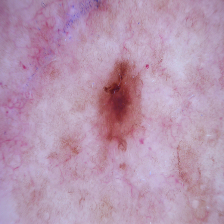

In [88]:
pil_img

In [89]:
from alibi.explainers import AnchorImage
image_shape = (224,224,3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(batch_predict, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

In [90]:
np.random.seed(4)
explanation = explainer.explain(np.array(pill_transf(pil_img)), threshold=.75, p_sample=.5, tau=0.25)

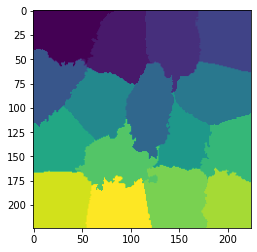

In [91]:
plt.imshow(explanation.segments)


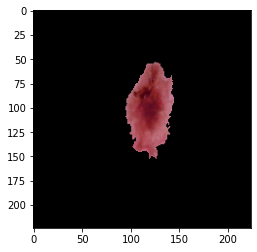

In [92]:
plt.imshow(explanation.anchor)

In [93]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred.squeeze().argmax()

0

In [94]:
label[16]

tensor(0)

In [95]:
img = np.transpose(input_original.cpu().detach().numpy()[17,:,:,:],(1,2,0))
img1 = img.astype(np.uint8)
pil_img = Image.fromarray(img1).convert('RGB')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   


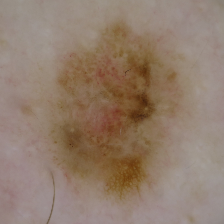

In [96]:
pil_img

In [97]:
from alibi.explainers import AnchorImage
image_shape = (224,224,3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(batch_predict, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

In [98]:
np.random.seed(5)
explanation = explainer.explain(np.array(pill_transf(pil_img)), threshold=.75, p_sample=.5, tau=0.25)

In [99]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred.squeeze().argmax()

0

In [100]:
label[17]

tensor(0)

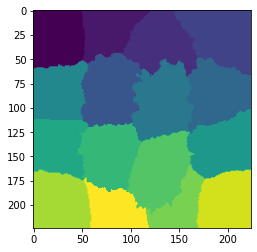

In [101]:
plt.imshow(explanation.segments)


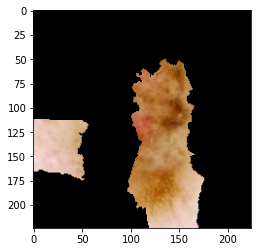

In [102]:
plt.imshow(explanation.anchor)

In [105]:
img = np.transpose(input_original.cpu().detach().numpy()[18,:,:,:],(1,2,0))
img1 = img.astype(np.uint8)
pil_img = Image.fromarray(img1).convert('RGB')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   

from alibi.explainers import AnchorImage
image_shape = (224,224,3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(batch_predict, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

In [106]:
np.random.seed(6)
explanation = explainer.explain(np.array(pill_transf(pil_img)), threshold=.75, p_sample=.5, tau=0.25)

In [107]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred.squeeze().argmax()

4

In [108]:
label[18]

tensor(4)

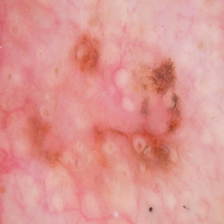

In [109]:
pil_img

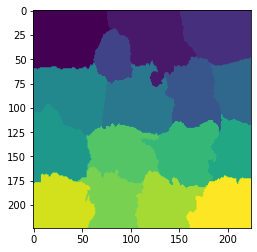

In [110]:
plt.imshow(explanation.segments)


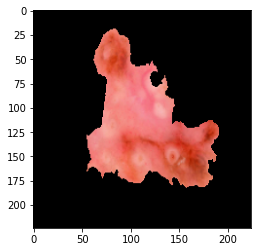

In [111]:
plt.imshow(explanation.anchor)

In [112]:
img = np.transpose(input_original.cpu().detach().numpy()[19,:,:,:],(1,2,0))
img1 = img.astype(np.uint8)
pil_img = Image.fromarray(img1).convert('RGB')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   

from alibi.explainers import AnchorImage
image_shape = (224,224,3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(batch_predict, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

In [113]:
np.random.seed(7)
explanation = explainer.explain(np.array(pill_transf(pil_img)), threshold=.75, p_sample=.5, tau=0.25)

In [114]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred.squeeze().argmax()

2

In [115]:
label[19]

tensor(2)

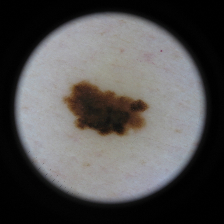

In [116]:
pil_img

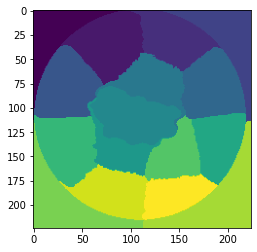

In [117]:
plt.imshow(explanation.segments)


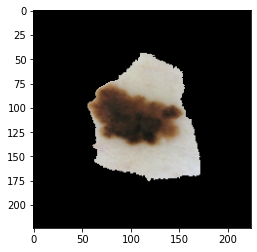

In [118]:
plt.imshow(explanation.anchor)

In [119]:
img = np.transpose(input_original.cpu().detach().numpy()[20,:,:,:],(1,2,0))
img1 = img.astype(np.uint8)
pil_img = Image.fromarray(img1).convert('RGB')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   

from alibi.explainers import AnchorImage
image_shape = (224,224,3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(batch_predict, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

In [132]:
np.random.seed(8)
explanation = explainer.explain(np.array(pill_transf(pil_img)), threshold=.75, p_sample=.5, tau=0.25)

In [133]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred.squeeze().argmax()

4

In [134]:
label[20]

tensor(4)

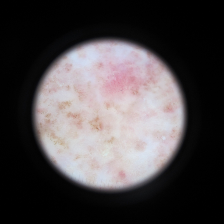

In [135]:
pil_img

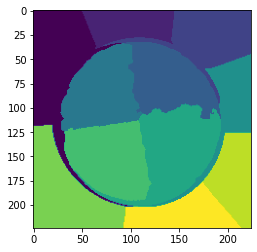

In [136]:
plt.imshow(explanation.segments)


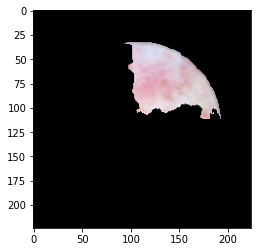

In [137]:
plt.imshow(explanation.anchor)
